# Scene Understanding using Deep Learning
## Introduction

This Notebook was written for demonstrating scene understanding for the Lockheed Martin drone challange. The code consists of three pipelines pre-processing, FCN and post processing  The project is a corner stone for  

\<img style="float: center;" src="readme_imgs/Img_groundtruth.png">

## Data Pre-processing 

We have implemented camera calibration routine to the video file.Each image was normalized and then smoothed with a Gaussian filter. The images were randomly processed with a brightness filter to help the network generalize to different lighting conditions. 

 


## FCN

 

 
 

##  Jaccard similarity coefficient 

In evaluating the model I've investigated several metrics including the Mean IU, Intersection over Union, and the Jaccard coefficient. The idea is to maximize the overlap between the predicted region and the ground truth bounding box.
 
We eventually decided to use the Jaccard coeef. The Jaccard similarity coefficient is defined as the size of the intersection divided by the size of the union of two regions. This metric is used to compare the predicted labels to a set of labels in y_true  

The coefficients are given by 

#### J(A,B) = |A∩B| / |A∪B|=|A∩B|/|A|+|B|-|A∩B| 

(If A and B are both empty, we define J(A,B) = 1.)

<img style="float: center;" src="readme_imgs/Intersection_of_sets_A_and_B.png">
<img style="float: center;" src="readme_imgs/Intersection_of_sets_A_and_B_2.png">
 

## Training

The Autti dataset was used and can be obtained from https://github.com/udacity/self-driving-car/tree/master/annotations .  

## Results
 

In [1]:
%matplotlib inline
import json
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import glob
import time

from scipy.ndimage.measurements import label
import pandas as pd
#import keras.backend as K
from sklearn.metrics import jaccard_similarity_score
 
import time
import numpy
from PIL import Image, ImageDraw
import re
from shapely.geometry import Polygon
from pprint import pprint
import PIL.ImageDraw
from PIL import Image
import argparse
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
 
#add a note for the class

# Reading and processing the wkt json format 


In [2]:
#df is the dataset that we are annotating
#raw_df is the dataset that the organizers provided
#adding path for json anf image folders respectively
provided_data_file_dir='/media/a/D/lockheed-martin/dataset/LM_dataset/csv/training_GT_labels_v2.json'#json provided by the organizers of the challange
our_data_file_dir='/media/a/D/lockheed-martin/dataset/LM_dataset/csv/data_wkt_v2.json'#our annotated dataset
img_file_dir='/media/a/D/lockheed-martin/dataset/LM_dataset/Data_Training/'#folder where images are stored
provided_df = pd.read_json(provided_data_file_dir)
df = pd.read_json(our_data_file_dir)

 
#adding a complete path for the image 
df['External ID']= [img_file_dir + u for u in df['External ID']]#iris_data_dir + new_df['parcel_id'].astype(str) + '.jpg'

df['images']=[u.split('/',8)[8] for u in df['External ID']]
raw_df=pd.DataFrame()
raw_df['images']=list(provided_df.columns.values)
raw_df['img_path']=[img_file_dir +  u for u in raw_df['images']]

raw_df['raw_inner_poly']=[ provided_df[u][0] for u in raw_df['images']]

raw_df.head()


,images,img_path,raw_inner_poly
0,IMG_5677.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[532, 354, 772, 357, 768, 594, 533, 592]"
1,IMG_7088 (1).JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[451, 226, 831, 247, 836, 623, 437, 622]"
2,IMG_0260.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[480, 373, 698, 374, 698, 599, 471, 594]"
3,IMG_4609.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[495, 309, 668, 285, 672, 554, 499, 533]"
4,IMG_2994.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[490, 190, 637, 345, 644, 686, 475, 679]"


In [3]:
#remove white spaces from image path
s=raw_df['images'][3]
print(re.sub(r"\s+", "", s))  # \s matches all white spaces

IMG_4609.JPG


#remove white space from image name in the folder containing the images

#go to img directory and run python fix.py. Here is the file

#remove white space from image name in the folder containing the images
import os
import re

""" 
Renames the filenames within the same directory to be Unix friendly
(1) Changes spaces to nothing
(2) Makes lowercase (not a Unix requirement, just looks better ;)
Usage:
python rename.py
"""
path =  os.getcwd()
 
filenames = os.listdir(path)

for filename in filenames:
    print('img name befor',filename)
    fixed_filename=re.sub(r"\s+", "", filename)
    print('img name after',fixed_filename)
    os.rename(filename, fixed_filename)

In [4]:
df.head()

,Agreement,Created At,Created By,DataRow ID,Dataset Name,External ID,ID,Label,Labeled Data,Project Name,Reviews,Seconds to Label,View Label,images
0,NaN,2019-02-06T08:35:37.000Z,alberto.galet@gmail.com,cjrsurb5r9p7w0anvd23j1pgg,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrsxucjqqkbd0b47j8vcjsua,{'Outer Border': [{'geometry': 'POLYGON ((997 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],33.832,https://image-segmentation-v4.labelbox.com?pro...,IMG_0015.JPG
1,NaN,2019-02-06T08:36:22.000Z,alberto.galet@gmail.com,cjrsurb5v9p800anv2xkrhfkw,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrsxvb54qkw90b47dwa8uupg,{'Outer Border': [{'geometry': 'POLYGON ((894 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],44.299,https://image-segmentation-v4.labelbox.com?pro...,IMG_0158.JPG
2,NaN,2019-02-06T08:36:55.000Z,alberto.galet@gmail.com,cjrsurb5v9p840anv7ly4rt5s,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrsxw0feqs9n08984nfshogi,{'Outer Border': [{'geometry': 'POLYGON ((848 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],31.955,https://image-segmentation-v4.labelbox.com?pro...,IMG_0244.JPG
3,NaN,2019-02-07T02:17:15.000Z,alberto.galet@gmail.com,cjrsurb5v9p880anvyjs4m1oj,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrtzrm18i8ga08983qewu7rq,{'Outer Border': [{'geometry': 'POLYGON ((597 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],39.032,https://image-segmentation-v4.labelbox.com?pro...,IMG_0367.JPG
4,NaN,2019-02-07T02:18:01.000Z,alberto.galet@gmail.com,cjrsurb5v9p8c0anvcve1d63y,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrtzslxpi69j0b4753lkl3ju,{'Outer Border': [{'geometry': 'POLYGON ((359 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],46.003,https://image-segmentation-v4.labelbox.com?pro...,IMG_0374.JPG


In [5]:
#merge the our annotations and provided annotations
df_all=pd.merge(df, raw_df, on='images')
df_all.head(10)

,Agreement,Created At,Created By,DataRow ID,Dataset Name,External ID,ID,Label,Labeled Data,Project Name,Reviews,Seconds to Label,View Label,images,img_path,raw_inner_poly
0,NaN,2019-02-06T08:35:37.000Z,alberto.galet@gmail.com,cjrsurb5r9p7w0anvd23j1pgg,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrsxucjqqkbd0b47j8vcjsua,{'Outer Border': [{'geometry': 'POLYGON ((997 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],33.832,https://image-segmentation-v4.labelbox.com?pro...,IMG_0015.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[504, 191, 902, 177, 915, 580, 495, 584]"
1,NaN,2019-02-06T08:36:22.000Z,alberto.galet@gmail.com,cjrsurb5v9p800anv2xkrhfkw,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrsxvb54qkw90b47dwa8uupg,{'Outer Border': [{'geometry': 'POLYGON ((894 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],44.299,https://image-segmentation-v4.labelbox.com?pro...,IMG_0158.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[454, 212, 803, 221, 808, 552, 454, 566]"
2,NaN,2019-02-06T08:36:55.000Z,alberto.galet@gmail.com,cjrsurb5v9p840anv7ly4rt5s,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrsxw0feqs9n08984nfshogi,{'Outer Border': [{'geometry': 'POLYGON ((848 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],31.955,https://image-segmentation-v4.labelbox.com?pro...,IMG_0244.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[590, 376, 791, 371, 794, 589, 577, 601]"
3,NaN,2019-02-07T02:17:15.000Z,alberto.galet@gmail.com,cjrsurb5v9p880anvyjs4m1oj,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrtzrm18i8ga08983qewu7rq,{'Outer Border': [{'geometry': 'POLYGON ((597 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],39.032,https://image-segmentation-v4.labelbox.com?pro...,IMG_0367.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[836, 385, 641, 387, 635, 582, 841, 582]"
4,NaN,2019-02-07T02:18:01.000Z,alberto.galet@gmail.com,cjrsurb5v9p8c0anvcve1d63y,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrtzslxpi69j0b4753lkl3ju,{'Outer Border': [{'geometry': 'POLYGON ((359 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],46.003,https://image-segmentation-v4.labelbox.com?pro...,IMG_0374.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[470, 221, 848, 231, 851, 613, 457, 609]"
5,NaN,2019-02-07T02:18:42.000Z,alberto.galet@gmail.com,cjrsurb5v9p8g0anv2ji1v57l,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrtzth7bi7210b47l0yydz0t,{'Outer Border': [{'geometry': 'POLYGON ((567 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],39.919,https://image-segmentation-v4.labelbox.com?pro...,IMG_0396.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[585, 338, 684, 354, 672, 523, 592, 532]"
6,NaN,2019-02-07T02:19:13.000Z,alberto.galet@gmail.com,cjrsurb5v9p8k0anv1auzm8e0,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrtzu5bziasw0898zn0xuaez,{'Outer Border': [{'geometry': 'POLYGON ((343 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],30.653,https://image-segmentation-v4.labelbox.com?pro...,IMG_0861.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[378, 468, 533, 480, 537, 646, 369, 646]"
7,NaN,2019-02-07T02:19:47.000Z,alberto.galet@gmail.com,cjrsurb5v9p8o0anv56veqecf,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrtzuvrni8r10b47jq56iqvh,{'Outer Border': [{'geometry': 'POLYGON ((753 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],33.630,https://image-segmentation-v4.labelbox.com?pro...,IMG_1128.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[509, 319, 705, 255, 705, 632, 506, 616]"
8,NaN,2019-02-07T02:20:22.000Z,alberto.galet@gmail.com,cjrsurb5v9p8s0anvm6kjs3ge,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/..

In [6]:

keep_cols=['images', 'img_path','Label','raw_inner_poly']
df_all=df_all[keep_cols]
df_all['outer_poly']=''
df_all['inner_poly']=''
df_all['outer_x_min']=''
df_all['outer_y_min']=''
df_all['outer_x_max']=''
df_all['outer_y_max']=''
df_all['inner_x_min']=''
df_all['inner_y_min']=''
df_all['inner_x_max']=''
df_all['inner_y_max']=''
df_all['class_id']= ''
print(len(df_all))
df_all.head()

2534


,images,img_path,Label,raw_inner_poly,outer_poly,inner_poly,outer_x_min,outer_y_min,outer_x_max,outer_y_max,inner_x_min,inner_y_min,inner_x_max,inner_y_max,class_id
0,IMG_0015.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,{'Outer Border': [{'geometry': 'POLYGON ((997 ...,"[504, 191, 902, 177, 915, 580, 495, 584]",,,,,,,,,,,
1,IMG_0158.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,{'Outer Border': [{'geometry': 'POLYGON ((894 ...,"[454, 212, 803, 221, 808, 552, 454, 566]",,,,,,,,,,,
2,IMG_0244.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,{'Outer Border': [{'geometry': 'POLYGON ((848 ...,"[590, 376, 791, 371, 794, 589, 577, 601]",,,,,,,,,,,
3,IMG_0367.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,{'Outer Border': [{'geometry': 'POLYGON ((597 ...,"[836, 385, 641, 387, 635, 582, 841, 582]",,,,,,,,,,,
4,IMG_0374.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,{'Outer Border': [{'geometry': 'POLYGON ((359 ...,"[470, 221, 848, 231, 851, 613, 457, 609]",,,,,,,,,,,


raw_inner_poly [511, 247, 850, 271, 853, 609, 506, 616]
poly [511, 247, 850, 271, 853, 609, 506, 616]
raw_inner_poly [492, 400, 665, 390, 667, 596, 489, 590]
poly [492, 400, 665, 390, 667, 596, 489, 590]


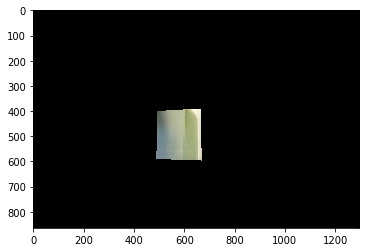

In [7]:
# checking the mask from the provided GT by the organizers



#processing the polygone and creating a mask
def get_mask_raw_data(img_shape, poly,display=False):
    output_mask = np.zeros(img_shape[:2], dtype=np.uint8)
    print('poly',poly)

    coords =  zip(*[iter(poly)] * 2) 
     
    mask = np.zeros(img_shape[:2], dtype=np.uint8)
    mask = PIL.Image.fromarray(mask)
    draw = PIL.ImageDraw.Draw(mask)
    x = []
    y = []
    polygons = []

    for pt in coords:
        a = (int(pt[0]), int(pt[1]))
        polygons.append(a)
        init_x = (int(pt[0]))
        init_y = (int(pt[1]))

        x.append(init_x)
        y.append(init_y)
    proc_polygons=np.vstack((x,y)).T
    x,y,w,h = cv2.boundingRect(proc_polygons) 
    draw.polygon(xy=polygons, outline=1, fill=1)
    mask = np.array(mask, dtype=bool)
    if display:
        plt.imshow(mask)
        plt.show
    return mask
for i in range(444,446):#len(df)):

    img=cv2.imread(df_all['img_path'][i])
    row=img.shape[0]
    col=img.shape[1]
    img_shape = (row,col)
    #outer_poly=df['Label'][i] 
    inner_poly=df_all['raw_inner_poly'][i]
    if inner_poly:
        print('raw_inner_poly',inner_poly)
    #outer_mask=get_mask(img_shape,outer_poly,display=False)
        inner_mask=get_mask_raw_data(img_shape,inner_poly,display=False)
        inner_mask.dtype='uint8'
    #outer_mask.dtype='uint8'
    #final_mask=cv2.subtract(outer_mask,inner_mask)
        plt.imshow(cv2.bitwise_and(img,img,mask=inner_mask))
        plt.show
    else:
        print('polygon data corruption detected for index:', i)

test_id=1
test_poly=df['Label'][test_id]['Outer Border']#df['outer_poly'][1] 


In [8]:
#convert the polygons into a format that can be convereted to bounding boxes 
from tqdm import tqdm
#preprocessing our_dataset

def convert_coordinates(poly):
    proc_poly=poly[0]['geometry']
    nums =  re.findall(r'\d+(?:\.\d*)?', proc_poly.rpartition(',')[0])
    coords =  zip(*[iter(nums)] * 2)
    polygons = []
    for pt in coords:
        a = (int(pt[0]), int(pt[1]))
        polygons.append(a)
    
    return polygons 
def convert_coordinates_raw(polygon):
    poly=[]
    polygon =  zip(*[iter(polygon)] * 2)
    for p in polygon:
        poly.append(p)
    return poly
def get_bbox(polygon):
    polygon=polygon[0]['geometry']
    polygon=(polygon)

    polygon =  re.findall(r'\d+(?:\.\d*)?', polygon)
    polygon =  zip(*[iter(polygon)] * 2)
    x = []
    y = []
    for pt in polygon:
        init_x = (int(pt[0]))
        init_y = (int(pt[1]))

        x.append(init_x)
        y.append(init_y)
    polygons=np.vstack((x,y)).T
   
    x,y,w,h = cv2.boundingRect(polygons)
    x_min=x
    y_min=y
    x_max=x+w
    y_max=y+h
    return x_min,y_min,x_max,y_max
    #return x_min,x_max,y_min,y_max
def get_bbox_raw_data(polygon):
    polygon =  zip(*[iter(polygon)] * 2)
    x = []
    y = []
    for pt in polygon:
 
        init_x = (int(pt[0]))
        init_y = (int(pt[1]))

        x.append(init_x)
        y.append(init_y)
    polygons=np.vstack(((x,y))).T
    
    x,y,w,h = cv2.boundingRect(polygons)
    x_min=x
    y_min=y
    x_max=x+w
    y_max=y+h
    return x_min,y_min,x_max,y_max
    #return x_min,x_max,y_min,y_max
for i in tqdm(range(0,len(df_all))):
    #remove white spaces from image path
   
    df_all['img_path'][i]=re.sub(r"\s+", "", df_all['img_path'][i]) # \s matches all white spaces
    outer_poly=df_all['Label'][i]['Outer Border']
    inner_poly=df_all['raw_inner_poly'][i]#df['Label'][i]['inner flyable area']
    if inner_poly and outer_poly:
        df_all['outer_poly'][i] = convert_coordinates(outer_poly)
        df_all['inner_poly'][i] = convert_coordinates_raw(inner_poly)
        #df['inner_poly'][i] = convert_coordinates(inner_poly)

        df_all['outer_x_min'][i],df_all['outer_y_min'][i], df_all['outer_x_max'][i],df_all['outer_y_max'][i]=get_bbox(outer_poly)
        df_all['inner_x_min'][i],df_all['inner_y_min'][i], df_all['inner_x_max'][i],df_all['inner_y_max'][i]=get_bbox_raw_data(inner_poly)
        #df_all['outer_x_min'][i],df_all['outer_x_max'][i], df_all['outer_y_min'][i],df_all['outer_y_max'][i]=get_bbox(outer_poly)
        #df_all['inner_x_min'][i],df_all['inner_x_max'][i], df_all['inner_y_min'][i],df_all['inner_y_max'][i]=get_bbox_raw_data(inner_poly) 
    else:
        print('corrupt data detected for index:', i )
        continue
    #df['outer_poly']= h
   #df['inner_poly']= convert_coordinates(inner_poly)

100%|██████████| 2534/2534 [00:01<00:00, 1480.02it/s]


In [9]:
df_all.head()

,images,img_path,Label,raw_inner_poly,outer_poly,inner_poly,outer_x_min,outer_y_min,outer_x_max,outer_y_max,inner_x_min,inner_y_min,inner_x_max,inner_y_max,class_id
0,IMG_0015.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,{'Outer Border': [{'geometry': 'POLYGON ((997 ...,"[504, 191, 902, 177, 915, 580, 495, 584]","[(997, 65), (1014, 683), (402, 673), (416, 106)]","[(504, 191), (902, 177), (915, 580), (495, 584)]",402,65,1015,684,495,177,916,585,
1,IMG_0158.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,{'Outer Border': [{'geometry': 'POLYGON ((894 ...,"[454, 212, 803, 221, 808, 552, 454, 566]","[(894, 638), (375, 646), (383, 136), (882, 141)]","[(454, 212), (803, 221), (808, 552), (454, 566)]",375,136,895,647,454,212,809,567,
2,IMG_0244.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,{'Outer Border': [{'geometry': 'POLYGON ((848 ...,"[590, 376, 791, 371, 794, 589, 577, 601]","[(848, 312), (851, 649), (533, 639), (538, 328)]","[(590, 376), (791, 371), (794, 589), (577, 601)]",533,312,852,650,577,371,795,602,
3,IMG_0367.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,{'Outer Border': [{'geometry': 'POLYGON ((597 ...,"[836, 385, 641, 387, 635, 582, 841, 582]","[(597, 623), (880, 627), (881, 344), (603, 346)]","[(836, 385), (641, 387), (635, 582), (841, 582)]",597,344,882,628,635,385,842,583,
4,IMG_0374.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,{'Outer Border': [{'geometry': 'POLYGON ((359 ...,"[470, 221, 848, 231, 851, 613, 457, 609]","[(359, 703), (950, 711), (943, 141), (384, 128)]","[(470, 221), (848, 231), (851, 613), (457, 609)]",359,128,951,712,457,221,852,614,


In [10]:
#keep only filed required by yolov3. Divide the dataframe into outer and inner bounding boxes and then assign a class to each one of them 
keep_cols_outer=['img_path', 'outer_x_min', 'outer_y_min', 'outer_x_max', 'outer_y_max','outer_poly','class_id']
keep_cols_inner=['img_path', 'inner_x_min', 'inner_y_min', 'inner_x_max', 'inner_y_max', 'inner_poly','class_id']
df_outer=df_all[keep_cols_outer]
df_inner=df_all[keep_cols_inner]
df_outer['class_id']=0
df_inner['class_id']=1
df_enet=pd.merge(df_outer, df_inner, on='img_path')
df_enet.head()

,img_path,outer_x_min,outer_y_min,outer_x_max,outer_y_max,outer_poly,class_id_x,inner_x_min,inner_y_min,inner_x_max,inner_y_max,inner_poly,class_id_y
0,/media/a/D/lockheed-martin/dataset/LM_dataset/...,402,65,1015,684,"[(997, 65), (1014, 683), (402, 673), (416, 106)]",0,495,177,916,585,"[(504, 191), (902, 177), (915, 580), (495, 584)]",1
1,/media/a/D/lockheed-martin/dataset/LM_dataset/...,375,136,895,647,"[(894, 638), (375, 646), (383, 136), (882, 141)]",0,454,212,809,567,"[(454, 212), (803, 221), (808, 552), (454, 566)]",1
2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,533,312,852,650,"[(848, 312), (851, 649), (533, 639), (538, 328)]",0,577,371,795,602,"[(590, 376), (791, 371), (794, 589), (577, 601)]",1
3,/media/a/D/lockheed-martin/dataset/LM_dataset/...,597,344,882,628,"[(597, 623), (880, 627), (881, 344), (603, 346)]",0,635,385,842,583,"[(836, 385), (641, 387), (635, 582), (841, 582)]",1
4,/media/a/D/lockheed-martin/dataset/LM_dataset/...,359,128,951,712,"[(359, 703), (950, 711), (943, 141), (384, 128)]",0,457,221,852,614,"[(470, 221), (848, 231), (851, 613), (457, 609)]",1


outer poly [(537, 272), (903, 291), (909, 659), (535, 669)]
inner_poly [(582, 324), (831, 342), (843, 584), (589, 590)]
outer poly [(403, 160), (385, 742), (908, 715), (905, 214), (515, 160), (403, 147)]
inner_poly [(476, 243), (820, 285), (825, 639), (470, 649)]
outer poly [(201, 185), (688, 150), (679, 723), (198, 677)]
inner_poly [(279, 255), (603, 247), (597, 627), (278, 604)]
outer poly [(411, 255), (732, 269), (735, 585), (408, 589)]
inner_poly [(461, 312), (677, 316), (689, 539), (464, 532)]
outer poly [(234, 13), (831, 147), (858, 726), (171, 739)]
inner_poly [(319, 146), (737, 219), (751, 632), (292, 623)]
outer poly [(579, 272), (890, 274), (899, 586), (589, 598)]
inner_poly [(627, 323), (839, 321), (843, 535), (630, 542)]
outer poly [(351, 64), (977, 56), (1003, 693), (337, 700)]
inner_poly [(440, 165), (879, 169), (884, 584), (437, 590)]
outer poly [(459, 377), (562, 357), (564, 569), (458, 556)]
inner_poly [(483, 402), (540, 397), (540, 527), (489, 521)]
outer poly [(567, 

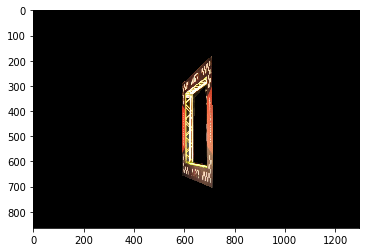

In [11]:
# testing annotation all together 

def get_mask(img_shape, poly,display=False):
     

    mask = np.zeros(img_shape[:2], dtype=np.uint8)
    mask = PIL.Image.fromarray(mask)
    draw = PIL.ImageDraw.Draw(mask)
    polygons = []
    for pt in poly:
        a = (int(pt[0]), int(pt[1]))
        polygons.append(a)
    
    draw.polygon(xy=polygons, outline=1, fill=1)
    mask = np.array(mask, dtype=bool)
    if display:
        plt.imshow(mask)
        plt.show
    return mask
#getting the final mask

for i in range(100,110):#len(df)): # use one image only for testing

    img=cv2.imread(df_enet['img_path'][i])
    row=img.shape[0]
    col=img.shape[1]
    img_shape = (row,col)
    outer_poly=df_enet['outer_poly'][i] 
    print('outer poly',outer_poly)
    inner_poly=df_enet['inner_poly'][i]
    print('inner_poly', list(inner_poly))
    outer_mask=get_mask(img_shape,outer_poly,display=False)
    inner_mask=get_mask(img_shape,inner_poly,display=False)
    inner_mask.dtype='uint8'
    outer_mask.dtype='uint8'
    final_mask=cv2.subtract(outer_mask,inner_mask)
    plt.imshow(cv2.bitwise_and(img,img,mask=final_mask))
    plt.show

In [12]:
print(len(df_enet))

2534


Create the ENet model
We decided to to split the model to three sub classes:

1) Initial block

2) RDDNeck - class for regular, downsampling and dilated bottlenecks

3) ASNeck - class for asymetric bottlenecks

4) UBNeck - class for upsampling bottlenecks

In [13]:
class InitialBlock(nn.Module):
  
  # Initial block of the model:
  #         Input
  #        /     \
  #       /       \
  #maxpool2d    conv2d-3x3
  #       \       /  
  #        \     /
  #      concatenate
   
    def __init__ (self,in_channels = 3,out_channels = 13):
        super().__init__()


        self.maxpool = nn.MaxPool2d(kernel_size=2, 
                                      stride = 2, 
                                      padding = 0)

        self.conv = nn.Conv2d(in_channels, 
                                out_channels,
                                kernel_size = 3,
                                stride = 2, 
                                padding = 1)

        self.prelu = nn.PReLU(16)

        self.batchnorm = nn.BatchNorm2d(out_channels)
  
    def forward(self, x):
        
        main = self.conv(x)
        main = self.batchnorm(main)
        
        side = self.maxpool(x)
        
        # concatenating on the channels axis
        x = torch.cat((main, side), dim=1)
        x = self.prelu(x)
        
        return x

In [14]:
class UBNeck(nn.Module):
    
  # Upsampling bottleneck:
  #     Bottleneck Input
  #        /        \
  #       /          \
  # conv2d-1x1     convTrans2d-1x1
  #      |             | PReLU
  #      |         convTrans2d-3x3
  #      |             | PReLU
  #      |         convTrans2d-1x1
  #      |             |
  # maxunpool2d    Regularizer
  #       \           /  
  #        \         /
  #      Summing + PReLU
  #
  #  Params: 
  #  projection_ratio - ratio between input and output channels
  #  relu - if True: relu used as the activation function else: Prelu us used
  
    def __init__(self, in_channels, out_channels, relu=False, projection_ratio=4):
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.reduced_depth = int(in_channels / projection_ratio)
        self.out_channels = out_channels
        
        
        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()
        
        self.unpool = nn.MaxUnpool2d(kernel_size = 2,
                                     stride = 2)
        
        self.main_conv = nn.Conv2d(in_channels = self.in_channels,
                                    out_channels = self.out_channels,
                                    kernel_size = 1)
        
        self.dropout = nn.Dropout2d(p=0.1)
        
        
        self.convt1 = nn.ConvTranspose2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               padding = 0,
                               bias = False)
        
        
        self.prelu1 = activation
        
        # This layer used for Upsampling
        self.convt2 = nn.ConvTranspose2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = 3,
                                  stride = 2,
                                  padding = 1,
                                  output_padding = 1,
                                  bias = False)
        
        self.prelu2 = activation
        
        self.convt3 = nn.ConvTranspose2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  padding = 0,
                                  bias = False)
        
        self.prelu3 = activation
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x, indices):
        x_copy = x
        
        # Side Branch
        x = self.convt1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.convt2(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.convt3(x)
        x = self.batchnorm2(x)
        
        x = self.dropout(x)
        
        # Main Branch
        
        x_copy = self.main_conv(x_copy)
        x_copy = self.unpool(x_copy, indices, output_size=x.size())
        
        # summing the main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        return x

In [15]:
class RDDNeck(nn.Module):
    def __init__(self, dilation, in_channels, out_channels, down_flag, relu=False, projection_ratio=4, p=0.1):
      
  # Regular|Dilated|Downsampling bottlenecks:
  #
  #     Bottleneck Input
  #        /        \
  #       /          \
  # maxpooling2d   conv2d-1x1
  #      |             | PReLU
  #      |         conv2d-3x3
  #      |             | PReLU
  #      |         conv2d-1x1
  #      |             |
  #  Padding2d     Regularizer
  #       \           /  
  #        \         /
  #      Summing + PReLU
  #
  # Params: 
  #  dilation (bool) - if True: creating dilation bottleneck
  #  down_flag (bool) - if True: creating downsampling bottleneck
  #  projection_ratio - ratio between input and output channels
  #  relu - if True: relu used as the activation function else: Prelu us used
  #  p - dropout ratio
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        
        self.out_channels = out_channels
        self.dilation = dilation
        self.down_flag = down_flag
        
        # calculating the number of reduced channels
        if down_flag:
            self.stride = 2
            self.reduced_depth = int(in_channels // projection_ratio)
        else:
            self.stride = 1
            self.reduced_depth = int(out_channels // projection_ratio)
        
        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()
        
        self.maxpool = nn.MaxPool2d(kernel_size = 2,
                                      stride = 2,
                                      padding = 0, return_indices=True)
        

        
        self.dropout = nn.Dropout2d(p=p)

        self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               stride = 1,
                               padding = 0,
                               bias = False,
                               dilation = 1)
        
        self.prelu1 = activation
        
        self.conv2 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = 3,
                                  stride = self.stride,
                                  padding = self.dilation,
                                  bias = True,
                                  dilation = self.dilation)
                                  
        self.prelu2 = activation
        
        self.conv3 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  stride = 1,
                                  padding = 0,
                                  bias = False,
                                  dilation = 1)
        
        self.prelu3 = activation
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
        
    def forward(self, x):
        
        bs = x.size()[0]
        x_copy = x
        
        # Side Branch
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.conv2(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.conv3(x)
        x = self.batchnorm2(x)
                
        x = self.dropout(x)
        
        # Main Branch
        if self.down_flag:
            x_copy, indices = self.maxpool(x_copy)
          
        if self.in_channels != self.out_channels:
            out_shape = self.out_channels - self.in_channels
            
            #padding and concatenating in order to match the channels axis of the side and main branches
            extras = torch.zeros((bs, out_shape, x.shape[2], x.shape[3]))
            if torch.cuda.is_available():
                extras = extras.cuda()
            x_copy = torch.cat((x_copy, extras), dim = 1)

        # Summing main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        if self.down_flag:
            return x, indices
        else:
            return x

In [16]:
class ASNeck(nn.Module):
    def __init__(self, in_channels, out_channels, projection_ratio=4):
      
  # Asymetric bottleneck:
  #
  #     Bottleneck Input
  #        /        \
  #       /          \
  #      |         conv2d-1x1
  #      |             | PReLU
  #      |         conv2d-1x5
  #      |             |
  #      |         conv2d-5x1
  #      |             | PReLU
  #      |         conv2d-1x1
  #      |             |
  #  Padding2d     Regularizer
  #       \           /  
  #        \         /
  #      Summing + PReLU
  #
  # Params:    
  #  projection_ratio - ratio between input and output channels
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.reduced_depth = int(in_channels / projection_ratio)
        self.out_channels = out_channels
        
        self.dropout = nn.Dropout2d(p=0.1)
        
        self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               stride = 1,
                               padding = 0,
                               bias = False)
        
        self.prelu1 = nn.PReLU()
        
        self.conv21 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = (1, 5),
                                  stride = 1,
                                  padding = (0, 2),
                                  bias = False)
        
        self.conv22 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = (5, 1),
                                  stride = 1,
                                  padding = (2, 0),
                                  bias = False)
        
        self.prelu2 = nn.PReLU()
        
        self.conv3 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  stride = 1,
                                  padding = 0,
                                  bias = False)
        
        self.prelu3 = nn.PReLU()
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x):
        bs = x.size()[0]
        x_copy = x
        
        # Side Branch
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.conv21(x)
        x = self.conv22(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.conv3(x)
                
        x = self.dropout(x)
        x = self.batchnorm2(x)
        
        # Main Branch
        
        if self.in_channels != self.out_channels:
            out_shape = self.out_channels - self.in_channels
            
            #padding and concatenating in order to match the channels axis of the side and main branches
            extras = torch.zeros((bs, out_shape, x.shape[2], x.shape[3]))
            if torch.cuda.is_available():
                extras = extras.cuda()
            x_copy = torch.cat((x_copy, extras), dim = 1)
        
        # Summing main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        return x

In [17]:
class ENet(nn.Module):
  
  # Creating Enet model!
  
    def __init__(self, C):
        super().__init__()
        
        # Define class variables
        # C - number of classes
        self.C = C
        
        # The initial block
        self.init = InitialBlock()
        
        
        # The first bottleneck
        self.b10 = RDDNeck(dilation=1, 
                           in_channels=16, 
                           out_channels=64, 
                           down_flag=True, 
                           p=0.01)
        
        self.b11 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b12 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b13 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b14 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        
        # The second bottleneck
        self.b20 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=128, 
                           down_flag=True)
        
        self.b21 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b22 = RDDNeck(dilation=2, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b23 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b24 = RDDNeck(dilation=4, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b25 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b26 = RDDNeck(dilation=8, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b27 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b28 = RDDNeck(dilation=16, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        
        # The third bottleneck
        self.b31 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b32 = RDDNeck(dilation=2, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b33 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b34 = RDDNeck(dilation=4, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b35 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b36 = RDDNeck(dilation=8, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b37 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b38 = RDDNeck(dilation=16, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        
        # The fourth bottleneck
        self.b40 = UBNeck(in_channels=128, 
                          out_channels=64, 
                          relu=True)
        
        self.b41 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           relu=True)
        
        self.b42 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           relu=True)
        
        
        # The fifth bottleneck
        self.b50 = UBNeck(in_channels=64, 
                          out_channels=16, 
                          relu=True)
        
        self.b51 = RDDNeck(dilation=1, 
                           in_channels=16, 
                           out_channels=16, 
                           down_flag=False, 
                           relu=True)
        
        
        # Final ConvTranspose Layer
        self.fullconv = nn.ConvTranspose2d(in_channels=16, 
                                           out_channels=self.C, 
                                           kernel_size=3, 
                                           stride=2, 
                                           padding=1, 
                                           output_padding=1,
                                           bias=False)
        
        
    def forward(self, x):
        
        # The initial block
        x = self.init(x)
        
        # The first bottleneck
        x, i1 = self.b10(x)
        x = self.b11(x)
        x = self.b12(x)
        x = self.b13(x)
        x = self.b14(x)
        
        # The second bottleneck
        x, i2 = self.b20(x)
        x = self.b21(x)
        x = self.b22(x)
        x = self.b23(x)
        x = self.b24(x)
        x = self.b25(x)
        x = self.b26(x)
        x = self.b27(x)
        x = self.b28(x)
        
        # The third bottleneck
        x = self.b31(x)
        x = self.b32(x)
        x = self.b33(x)
        x = self.b34(x)
        x = self.b35(x)
        x = self.b36(x)
        x = self.b37(x)
        x = self.b38(x)
        
        # The fourth bottleneck
        x = self.b40(x, i2)
        x = self.b41(x)
        x = self.b42(x)
        
        # The fifth bottleneck
        x = self.b50(x, i1)
        x = self.b51(x)
        
        # Final ConvTranspose Layer
        x = self.fullconv(x)
        
        return x

In [18]:
#Instantiate the ENet model
enet = ENet(2)

In [19]:
# Checking if there is any gpu available and pass the model to gpu or cpu
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
enet = enet.to(device)

In [20]:
img = plt.imread(df_enet['img_path'][8])
print(img.shape)

(864, 1296, 3)


In [24]:
#build a generater
from ImgAugumentation import ImgAugumentation
img_augumentation = ImgAugumentation()
def loader(df, batch_size, im_size=(512,512), aug=False):
    total_files_s=len(df)
    if str(batch_size).lower() == 'all':
        batch_size = total_files_s
    idx = 0
    while(1):
      # Choosing random indexes of images and labels
        batch_idxs = np.random.randint(0, total_files_s, batch_size)
   
        
        inputs = []
        labels = []
        
        for jj in batch_idxs:
          # Reading normalized photo
        
 
            img = plt.imread(df['img_path'][jj])
            orginal_im_size=img.shape
          # Resizing using nearest neighbor method
            img = cv2.resize(img, (im_size[0], im_size[1]), cv2.INTER_NEAREST)
            
          # creating semantic mask 
            outer_poly=df['outer_poly'][jj] 
            #print('outer poly',outer_poly)
            inner_poly=df['inner_poly'][jj]
            #print('inner_poly', list(inner_poly))
            outer_mask=get_mask((orginal_im_size[0], orginal_im_size[1]),outer_poly,display=False)
            inner_mask=get_mask((orginal_im_size[0], orginal_im_size[1]),inner_poly,display=False)
            inner_mask.dtype='uint8'
            outer_mask.dtype='uint8'
            final_mask=cv2.subtract(outer_mask,inner_mask)
          # Resizing using nearest neighbor method
            final_mask = cv2.resize(final_mask, (im_size[0], im_size[1]), cv2.INTER_NEAREST)
            if aug:
                rand_value_augument = np.random.randint(7)
                if (rand_value_augument == 0):   
                    img, final_mask=img_augumentation.flip_image_horz(img, final_mask)
                if (rand_value_augument == 1): 
                    img, final_mask=img_augumentation.flip_image_ver(img, final_mask)
                if (rand_value_augument == 2) or (rand_value_augument == 3): 
                    img=img_augumentation.brightness_images(img)
                if (rand_value_augument == 4): 
                    img, final_mask =img_augumentation.trans_image(img,final_mask,50)
                if (rand_value_augument == 5): 
                    img, final_mask =img_augumentation.stretch_image(img, final_mask,-100)
                if (rand_value_augument == 6): 
                    img, final_mask =img_augumentation.stretch_image(img, final_mask,-50)
                if (rand_value_augument == 7): 
                    img, final_mask =img_augumentation.stretch_image(img, final_mask,+30)
            inputs.append(img)
            labels.append(final_mask)

        inputs = np.stack(inputs, axis=2)
      # Changing image format to C x H x W
        inputs = torch.tensor(inputs).transpose(0, 2).transpose(1, 3)
        
        labels = torch.tensor(labels)
        
        yield inputs, labels

torch.Size([512, 512])


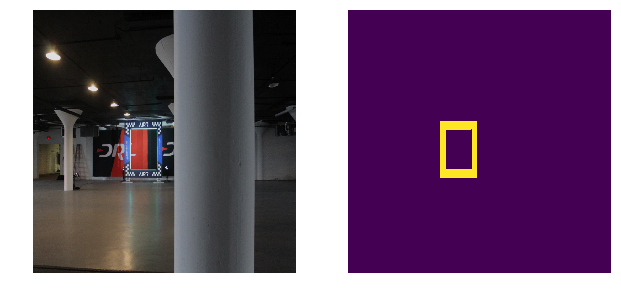

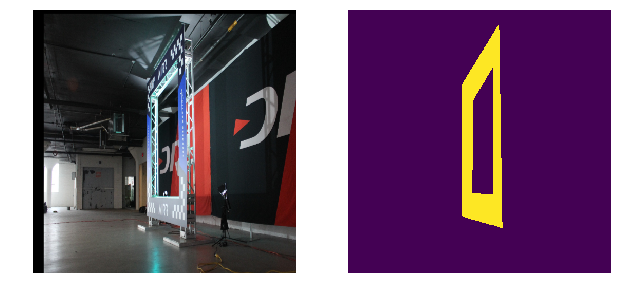

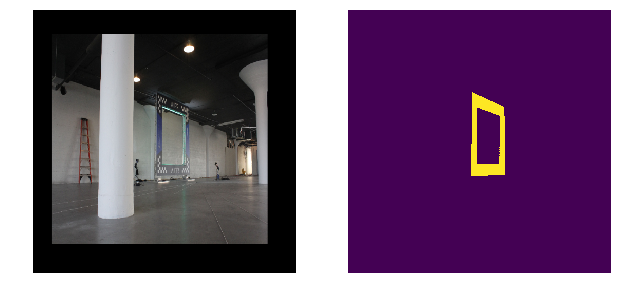

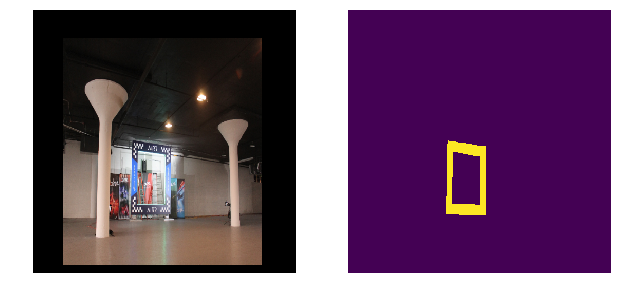

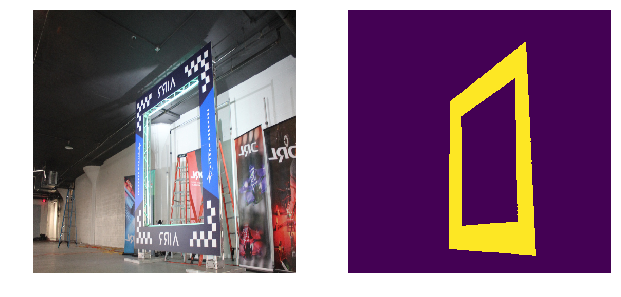

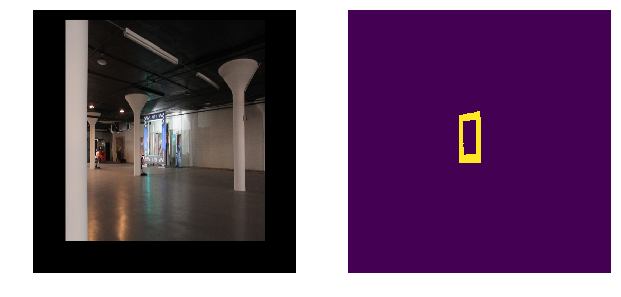

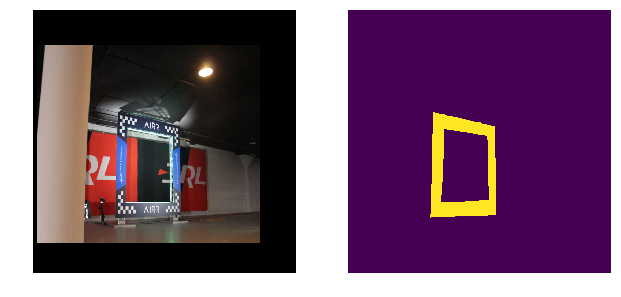

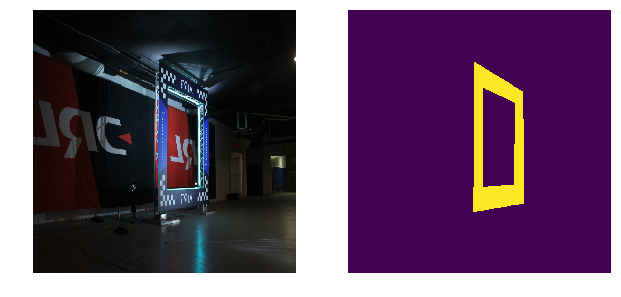

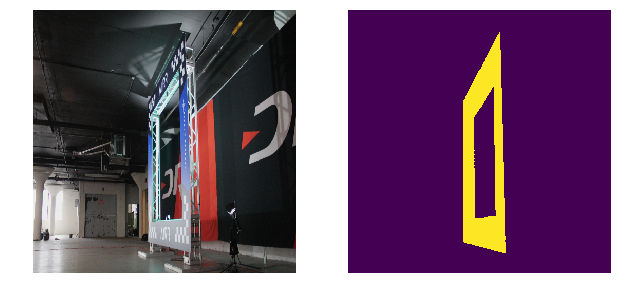

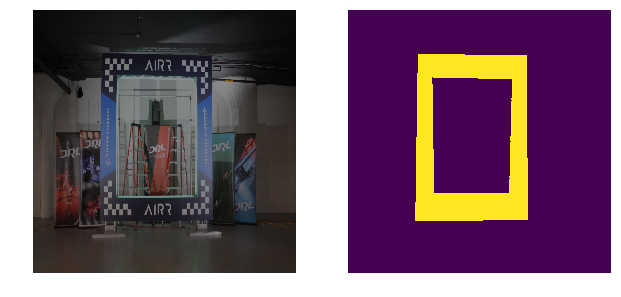

In [23]:
#test the generater
batch_size=10
training_gen=loader(df_enet, batch_size, aug=True)
batch_img,batch_mask = next(training_gen)
print(batch_mask[0].shape)

for i in range(0,len(batch_img)):
 
    plt.figure(figsize=(16,16))
    plt.subplot(1,3,1)
    plt.imshow(batch_img[i])
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(batch_mask[i])
    plt.axis('off')

    plt.show();

In [25]:
def get_class_weights(num_classes, c=1.02):
    pipe = loader(df_enet, batch_size='all',aug=True)
    _, labels = next(pipe)
    all_labels = labels.flatten()
    each_class = np.bincount(all_labels, minlength=num_classes)
    prospensity_score = each_class / len(all_labels)
    class_weights = 1 / (np.log(c + prospensity_score))
    return class_weights

In [26]:
class_weights = get_class_weights(1)


In [27]:
print(class_weights)

[  1.48861367  12.64282076]


In [28]:
lr = 5e-4
batch_size = 20

criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
optimizer = torch.optim.Adam(enet.parameters(), 
                             lr=lr,
                             weight_decay=2e-4)

print_every = 4
eval_every = 10

In [29]:
print(len(df_enet))

2534


In [ ]:
#splitting the dataset into training and testing
from sklearn.model_selection import train_test_split
df_trn, df_tst = train_test_split(df_enet, test_size=0.03)
print(len(df_trn))
print(len(df_tst))


2457
77


In [ ]:
df_trn.reset_index(drop=True, inplace=True)
df_tst.reset_index(drop=True, inplace=True)
df_trn.head()

,img_path,outer_x_min,outer_y_min,outer_x_max,outer_y_max,outer_poly,class_id_x,inner_x_min,inner_y_min,inner_x_max,inner_y_max,inner_poly,class_id_y
0,/media/a/D/lockheed-martin/dataset/LM_dataset/...,560,348,696,611,"[(560, 383), (694, 348), (695, 610), (561, 599)]",0,587,383,674,564,"[(590, 409), (673, 383), (673, 563), (587, 563)]",1
1,/media/a/D/lockheed-martin/dataset/LM_dataset/...,535,241,692,655,"[(539, 241), (691, 312), (690, 623), (535, 654)]",0,566,323,647,579,"[(570, 323), (644, 355), (646, 571), (566, 578)]",1
2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,426,8,1012,830,"[(427, 161), (997, 8), (1011, 829), (426, 729)]",0,514,167,901,693,"[(516, 241), (898, 167), (900, 692), (514, 649)]",1
3,/media/a/D/lockheed-martin/dataset/LM_dataset/...,448,301,729,613,"[(448, 320), (724, 301), (728, 612), (448, 606)]",0,482,347,688,559,"[(482, 364), (682, 347), (687, 558), (497, 556)]",1
4,/media/a/D/lockheed-martin/dataset/LM_dataset/...,537,364,678,683,"[(538, 407), (675, 364), (677, 682), (537, 658)]",0,577,426,659,628,"[(577, 447), (658, 426), (649, 627), (580, 618)]",1


#create overfitting dataset
df_trn, df_tst = train_test_split(df_tst, test_size=0.1)
print(len(df_trn))
print(len(df_tst))
df_trn.reset_index(drop=True, inplace=True)
df_tst.reset_index(drop=True, inplace=True)
df_trn.head()

In [ ]:
train_losses = []
eval_losses = []

bc_train = 100# 1 // batch_size # mini_batch train
bc_eval = 77# // batch_size  # mini_batch validation

# Define pipeline objects
pipe = loader(df_trn, batch_size,aug=True)
eval_pipe = loader(df_tst, batch_size)

epochs = 1000

# Train loop

for e in range(1, epochs+1):
    
    
    train_loss = 0
    print ('-'*15,'Epoch %d' % e, '-'*15)
    
    enet.train()
    
    for _ in tqdm(range(bc_train)):
        X_batch, mask_batch = next(pipe)
        
        # assign data to cpu/gpu
        X_batch, mask_batch = X_batch.to(device), mask_batch.to(device)

        optimizer.zero_grad()

        out = enet(X_batch.float())
        #print(out.shape)
        # loss calculation
        loss = criterion(out, mask_batch.long())
        # update weights
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        
    print ()
    train_losses.append(train_loss)
    
    if (e+1) % print_every == 0:
        print ('Epoch {}/{}...'.format(e, epochs),
                'Loss {:6f}'.format(train_loss))
    
    if e % eval_every == 0:
        with torch.no_grad():
            enet.eval()
            
            eval_loss = 0

            # Validation loop
            for _ in tqdm(range(bc_eval)):
                inputs, labels = next(eval_pipe)

                inputs=inputs.float()
                inputs, labels = inputs.to(device), labels.to(device)
                    
                
                out = enet(inputs)
                
                out = out.data.max(1)[1]
                
                eval_loss += (labels.long() - out.long()).sum()
                
            
            print ()
            print ('Loss {:6f}'.format(eval_loss))
            
            eval_losses.append(eval_loss)
        
    if e % print_every == 0:
        checkpoint = {
            'epochs' : e,
            'state_dict' : enet.state_dict()
        }
        torch.save(checkpoint, 'content/ckpt-enet-{}-{}.pth'.format(e, train_loss))
        print ('Model saved!')

print ('Epoch {}/{}...'.format(e, epochs),
       'Total Mean Loss: {:6f}'.format(sum(train_losses) / epochs))

  0%|          | 0/100 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  0%|          | 0/100 [00:00<?, ?it/s]


--------------- Epoch 2 ---------------


  5%|▌         | 5/100 [00:06<02:01,  1.28s/it]

# Postprocessing pipeline

In [ ]:
sample_img=45 
tmg_ = plt.imread(df_tst['img_path'][sample_img])
img_size=tmg_.shape
print(img_size)
#tmg_ = cv2.resize(tmg_, (img_size[0], img_size[1]), cv2.INTER_NEAREST)
tmg = torch.tensor(tmg_).unsqueeze(0).float()
tmg = tmg.transpose(2, 3).transpose(1, 2).to(device)

enet.to(device)
with torch.no_grad():
    out1 = enet(tmg.float()).squeeze(0)

In [ ]:
 
outer_poly=df_tst['outer_poly'][sample_img] 
#print('outer poly',outer_poly)
inner_poly=df_tst['inner_poly'][sample_img]
#print('inner_poly', list(inner_poly))
outer_mask=get_mask((img_size[0], img_size[1]),outer_poly,display=False)
inner_mask=get_mask((img_size[0], img_size[1]),inner_poly,display=False)
inner_mask.dtype='uint8'
outer_mask.dtype='uint8'
final_mask=cv2.subtract(outer_mask,inner_mask)
plt.imshow(final_mask)
plt.show

In [ ]:
# Load a pretrained model if needed
enet = ENet(2)
state_dict = torch.load('content/ckpt-enet-1000.pth')['state_dict']
enet.load_state_dict(state_dict)

In [ ]:
out2 = out1.cpu().detach().numpy()

In [ ]:
mno = 1 # Should be between 0 - n-1 | where n is the number of classes

figure = plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.title('Input Image')
plt.axis('off')
plt.imshow(tmg_)
plt.subplot(1, 3, 2)
plt.title('Output Image')
plt.axis('off')
plt.imshow(out2[mno, :, :])
plt.show()

In [ ]:
b_ = out1.data.max(0)[1].cpu().numpy()

In [ ]:
def decode_segmap(image):
    gate = [128, 128, 128]
     

    label_colours = np.array([gate]).astype(np.uint8)
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    for l in range(0, 1):
        r[image == l] = label_colours[l, 0]
        g[image == l] = label_colours[l, 1]
        b[image == l] = label_colours[l, 2]

    rgb = np.zeros((image.shape[0], image.shape[1], 3)).astype(np.uint8)
    rgb[:, :, 0] = b
    rgb[:, :, 1] = g
    rgb[:, :, 2] = r
    return rgb


In [ ]:
true_seg = decode_segmap(final_mask)
pred_seg = decode_segmap(b_)

In [ ]:
figure = plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.title('Input Image')
plt.axis('off')
plt.imshow(tmg_)
plt.subplot(1, 3, 2)
plt.title('Predicted Segmentation')
plt.axis('off')
plt.imshow(pred_seg)
plt.subplot(1, 3, 3)
plt.title('Ground Truth')
plt.axis('off')
plt.imshow(true_seg)
plt.show()

# Training pipeline

# Post-processing pipeline      

In [ ]:
start = time.time()
training_gen = generate_train_batch(cars_15_35GB,1)
batch_img,batch_mask = next(training_gen)
end = time.time()
end-start

In [ ]:
start = time.time()
sample_imgs=1 
testing_gen = generate_test_batch(cars_15_35GB,sample_imgs)
pre_final_predictions= model.predict(batch_img)
end = time.time()
end-start

In [ ]:
### Test on last frames of data
start = time.time()
batch_img,batch_mask = next(testing_gen)
pre_final_predictions= model.predict(batch_img)
np.shape(pre_final_predictions)
for i in range(sample_imgs):
    im=batch_img[i]
    pred,im = next_img(im)
    im  = np.array(im,dtype= np.uint8)
    im_pred = np.array(255*pred[0],dtype=np.uint8)
    im_mask = np.array(255*batch_mask[i],dtype=np.uint8)
    rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
    rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
    rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]
    img_true = cv2.addWeighted(rgb_mask_true,0.70,im,0.70,0)
    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
    img_pred = cv2.addWeighted(rgb_mask_pred,0.70,im,1,0)
    draw_img = get_BB_new_img(im)
    plt.figure(figsize=(14,5))
    plt.subplot(1,4,1)
    plt.imshow(im)
    plt.title('Original')
    plt.axis('off')
    plt.subplot(1,4,2)
    plt.imshow(img_pred)
    plt.title('Segmented')
    plt.axis('off')
    plt.subplot(1,4,3)
    plt.imshow(draw_img)
    plt.title('Predicted')
    plt.axis('off')
    plt.subplot(1,4,4)
    plt.imshow(img_true)
    plt.title('Gtruth')
    plt.axis('off')

end = time.time()
end-start   

In [ ]:
test_img = 'scene01021.jpg'
im = cv2.imread(test_img)
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
pred,im = next_img(im)
im  = np.array(im,dtype= np.uint8)
im_pred = np.array(255*pred[0],dtype=np.uint8)
rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]

img_pred = cv2.addWeighted(rgb_mask_pred,0.70,im,1,0)

draw_img = get_BB_new_img(im)

plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
plt.imshow(im)
plt.title('Original')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(img_pred)
plt.title('Segmentated')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(draw_img)
plt.title('Bounding Box')
plt.axis('off');



## Performing camera calibration
Camera calibration is performed in order to correct the deformation in the images that is caused to the optic lens curvature. The first step is to print a chessboard and take random pictures of it. Then count the chess intersecting squires to provide "objp" which holds the (x,y,z) coordinates of these corners. Z=0 here and the object points are the same for all images in the calibration folder. The objpoints will be appended in "objp" every time the method successfully detect all chessboard corners in a test image. "imgpoints" will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.
"objpoints" and "imgpoints" were used to compute the camera calibration and distortion coefficients using the "cv2.calibrateCamera()" function on a test image in "cv2.undistort()"

In [ ]:
# prepare object points. The number of corners are 6x9
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
# Make a list of calibration images, all located in camera_cal
images = glob.glob('camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    # imread reads images in BGR format
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        #Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)
#cv2.destroyAllWindows()

## Perform distortion removal on test images¶
1. Has the distortion correction been correctly applied to each image?
Undistortion is performed on the provided test images before they are used in the pipeline. This also applies to the video frames. "dst" holds undistorted frames from "cv2.undistort" that were computed using "mtx".

In [ ]:
for image_name in glob.glob("Frames/*"):
    im = cv2.imread(image_name)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    im = undistort(im,read=False, display = False, write = False)
    pred,im = next_img(im)
    im  = np.array(im,dtype= np.uint8)
    im_pred = np.array(255*pred[0],dtype=np.uint8)
    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
    img_pred = cv2.addWeighted(rgb_mask_pred,0.50,im,1,0)
    draw_img = get_BB_new_img(im)
    plt.figure(figsize=(14,5))
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.title('Original')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(img_pred)
    plt.title('Segmentated')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(draw_img)
    plt.title('Bounding Box')
    plt.axis('off');

heatmap_10 = [np.zeros((640,960))]*10
    

In [ ]:
def video_pipeline(image):
    #test_img = 'scene01021.jpg'
    #im = cv2.imread(im)
    #im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    #img = get_BB_new_img(im)
    # Apply bounding box to image
    image_bb = np.copy(image)
    bbox_cars = get_BB_new(image_bb)
    img_size = np.shape(image)
    result = image
    img_res_shape = result.shape
    for bbox in bbox_cars:
        cv2.rectangle(result,(np.int32(bbox[0][0]*img_res_shape[1]/960),np.int32(bbox[0][1]*img_res_shape[0]/640)), (np.int32(bbox[1][0]*img_res_shape[1]/960),np.int32(bbox[1][1]*img_res_shape[0]/640)),(0,255,0),6)
    #heatmap = get_Unet_mask(image_bb)
    #plt.imshow(img)
    return result

In [ ]:
video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(video_pipeline) 
white_clip.write_videofile(video_output, audio=False)

In [ ]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('project_video_output.mp4'))